### Fashion-MNIST

This project takes an in-depth look into machine learning techniques and how to use pytorch -- for beginners. The data set of choice is the well-known Fashion-MNIST data set, which is composed of many images of fashion items (shirts, shoes, etc.). The data is labeled, meaning for every image we know exactly what it should be (an image of a shirt is given the shirt label). We take this from the beginning, as if pytorch has never been used before and you are just getting started. 

Some things that you need to install in your python environment if you do not have them already:

```
pytorch
numpy
matplotlib
tensorboard
pandas
```

I am running this on python 3.9. Using anaconda, I created a virtual environment (names py39-pytorch, you can name it whatever you'd like) and I installed all dependencies as such:

```
conda create -n py39-pytorch python=3.6
conda activate py39-pytorch
conda install pytorch torchvision -c pytorch 
conda install numpy
conda install matplotlib
conda install -c conda-forge tensorboard
conda install pandas
```

Now that dependencies are likely installed, lets import all the dependencies

In [62]:
# standard useful libraries
import matplotlib.pyplot as plt
import numpy as np

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

In [64]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [65]:
import time
import pandas as pd
import json
from IPython.display import clear_output
import random

In [66]:
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

Download the dataset from torchvision, which is a library that has the FashionMNIST dataset, among many other popular data sets. Provided is a training set and a testing set that we can grab. We specify the location to store the data, which is a directory named 'data' that will be located within the current working directory.

We are going to ultimately have a training set, a validation set, and a testing set. The training set is the set of data we will use to train our model and the validation set will be used to validate the model. As we train/validate, there is potential to over-fit the model to the data set using to train/validate. That is where the testing set comes in handy. Of course, in machine learning, this is always a battle. Depending on the size of your dataset, it is possible to not have the luxury of having so many samples to train/validate/test. In any case, the training/validation sets will be made up of the 'train' set from torch vision and the test set will be made up of the 'test' set from torch vision, and we will split the 'train' set into our training/validation sets. 

In [7]:
train_and_valid_set = torchvision.datasets.FashionMNIST("./data", download=True, train=True, transform=
                                                transforms.ToTensor())

In [8]:
print(f'The training set has {len(train_and_valid_set)} datapoints')

The training set has 60000 datapoints


The first step is to split the data into a train and validation set. The test set will be used to test the accuracy of the final results using the validation to assess accuracy originally. Pytortch is able to slpit data using the function: 

`torch.utils.data.dataset.random_split(dataset, [num_train, num_valid]).`

We will use an 80/20 split here. 80% of the data from the `train_and_valid_set` will be used for training, and 20% will be used for validation.

In [9]:
print('Number of data points in training set:\t', len(train_and_valid_set))
print('Number in split training set:\t\t', int(len(train_and_valid_set)*.8))
print('Number in validation set:\t\t', int(len(train_and_valid_set)*.2))

Number of data points in training set:	 60000
Number in split training set:		 48000
Number in validation set:		 12000


In [10]:
train_set, valid_set = torch.utils.data.dataset.random_split(train_and_valid_set, [48000, 12000])

The test set, as said previously, is also located within torchvision. We can download this as well, set train = False to get the test dataset.

In [11]:
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.ToTensor()) 

In [12]:
print(f'The test set has {len(test_set)} datapoints')

The test set has 10000 datapoints


Each sample is an image, that is a matrix of values that represent the grey-scale image, and an integer label that defines the item of clothing the image is. For clarity, we can access the description (or clothing item) associated with each label.

In [13]:
def output_label(label: 'torch.Tensor or int') -> str:
    '''
    This function solely takes in an integer label, that is type
    torch.Tensor or integer and returns the string that describes the label. 
    '''
    # create my output mapping dictionary, where the integer label
    # is the dictionary id and the label 
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    # sometimes the label is type torch.Tensor, for which we want 
    # the integer (or item) stored in there, otherwise, the id is 
    # just the integer label given
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Lets take a quick look at one data point. Lets just grab a radom data point (I am choosing the third sample here, just to make sure it is always the same when reloading the kernel) from the original data set.

In [14]:
random_image, random_image_label = train_set[3]

Lets look at the size of the image data:

In [15]:
random_image.shape

torch.Size([1, 28, 28])

The shape attribute tells us we have 1 matrix (sometimes in image data we will have 3 matrices representing the 3 channels of an RGB image, but here we are in gray-scale, which is only one channel, hence one matrix) of size 28 x 28. This means there are 784 pixels for the image, or 784 elements making up the data matrix storing the pixel data. Lets look at what the data for an image looks like:

In [16]:
random_image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1765, 0.8078, 0.5961, 0.5961, 0.3765,
          0.4824, 0.3216, 0.5529, 0.3294, 0.4627, 0.6118, 0.6196, 0.1098, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3098, 0.8706, 0.7725, 0.8902, 0.6275,
          1.0000, 0.6118, 0.5843, 0.7490, 0.8471, 0.8745, 1.0000, 0.3020, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2824, 0.6706, 0.6353, 0.8196, 0.4706,
          0.8549, 0.4863, 0.7490, 0.7020, 0.6667, 0.5608, 0.7020, 0.0784, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3725, 0.8235, 0.7490, 0.8667, 0.7059,
          0.9137, 0.7647, 0.9765, 0.7176, 0.6196, 0.5529, 0.7059, 0.2196, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       

As expected, the image array is a matrix of values. The values are between 0 and 1, where 0 is black and 1 is white, that make up the gray scale image. Sometimes this data set is not normalized between 0 and 1, but the data loader did that for us. Lets actually show that image. We can use the `imshow()` function to do so. As said previously, there are only 784 pixels, so it is likely the image quality will be relatively poor.

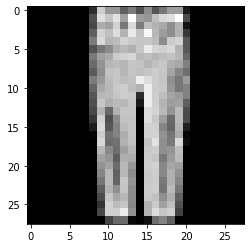

In [17]:
plt.imshow(random_image.squeeze(), cmap="gray")

Although blurry, we can clearly see the image is a trouser. Lets look at the integer label for this data point.

In [18]:
print('The integer label is:\t\t', random_image_label)
print('The description label is:\t', output_label(random_image_label))

The integer label is:		 1
The description label is:	 Trouser


Lets take a quick look at more of the data. Lets plot all the images in one batch, which should be a total images = batch size chosen previously. The `torchvision.utils.make_grid` function is great to show many images at once. We will also use the `torch.utils.data.DataLoader` to be able to iterate over the data. We are splitting up our data here into groups (or batches) of 50. This will come into play later when we begin training our model but for now we will just use it to show 50 random images. 

(-0.5, 241.5, 211.5, -0.5)

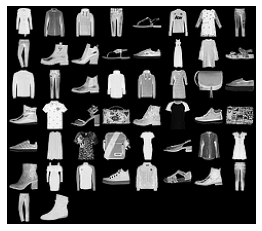

In [19]:
# split the data set into batches of 50 so we can iterate over 
# the images -- this will come into play again later
sets_of_50_images = torch.utils.data.DataLoader(train_set, 50)
random_50_images = iter(sets_of_50_images)

# the images variable here will contain the matrix data for the 
# gray scale image and the labels variable will hold an array 
# of the integer labels for each image. 
images, labels = random_50_images.next()

# make the grid of images, this is appending and arranging
# all the matrix data for each individual image into one larger
# matrix
gird_of_images = torchvision.utils.make_grid(images)

# use numpy to read in the image and show it using imshow
npimg = gird_of_images.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')

We can now see all the images in one of the batches. We see 50 different fashion images. This would mean that the variable holding all the labels for the image should be length 50, lets confirm this:

In [19]:
print('Number of labels for this batch:', labels.shape)

Number of labels for this batch: torch.Size([50])


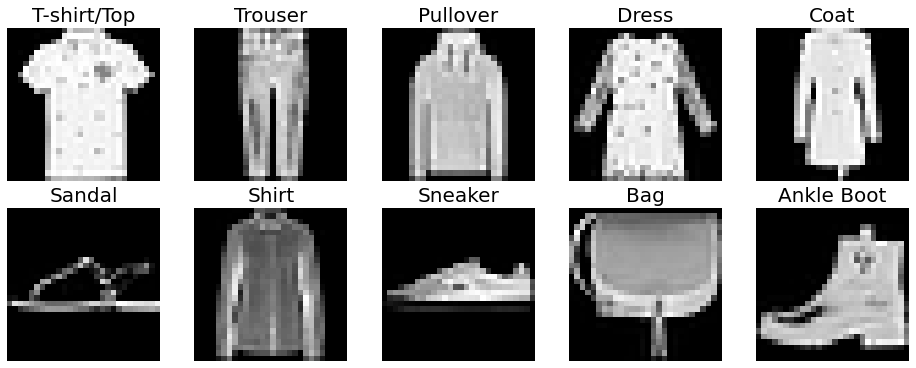

In [60]:
set_with_labels = []
has_labels = []
for i, label in enumerate(labels):
    if label not in has_labels:
        has_labels.append(label)
        set_with_labels.append((i, label))
set_with_labels.sort(key = lambda x: x[1]) 

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (13, 5), constrained_layout=True)

for i, set in enumerate(set_with_labels):
    j = 0 if i < 5 else 1
    img = images[set[0]]
    col = i if i < 5 else i-5
    ax[j][col].imshow(img.squeeze(), cmap="gray")
    ax[j][col].set_title(output_label(i), fontsize = 20)
    ax[j][col].axis('off')

The ultimate goal of this project is to investigating different machine learning techniques and determine the one with the best accuracy, all while also investigating hyperparameters that contribute to the success of the algorithms.

Some important notes:

The __batch size__ is a hyperparameter of gradient descent that controls the number of training samples to work through before the model's internal parameters are updated.

The number of __epochs__ is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset. 

- after one epoch, all training samples have been assessed, which would mean it has looked through all the batches once

The __learning rate__ is the rate at which model parameters are updated at each batch/epoch. Smaller values mean the model learns relatively slow. The learning rate is an essential hyperparameter in machine learning because it dictates how much your model learns from new observations versus how much it desires to disregard the past. 

Keep these definitions in mind as we go through this. These are the hypeparameters we will investigate and alter to control the learning and optimization process of our algorithm. 

Lets begin by defining a neural network. There are some important concepts to understand to actually create this model, so lets take it slow. With 2D (matrix) data, we first have to flatten the matrix. This makes the input features linear, which provides versatility in training. We can do this using the `nn.Flatten()` function. To see it in action, lets see how if modifies the matrix of one image.

In [20]:
flatten = nn.Flatten()
flat_image = flatten(random_image)
print('Before flattening:\t', random_image.shape)
print('After flattening:\t', flat_image.shape)

Before flattening:	 torch.Size([1, 28, 28])
After flattening:	 torch.Size([1, 784])


We can see that when we flatten the matrix, we are left with an array of size 784, which is 28*28. Now that we have flattened data, we can create layers for the neural network. We begin with a linear layer, which in pytorch is `nn.Linear` which is a module that transforms the data into a linear layer using the feature data given. You also have to specify the number of features you would like to output. This is essentially the number of nodes within that layer. This choice is something you can of course play with. For this example, we are using 20 nodes in this hidden layer. 

In [21]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.shape)

torch.Size([1, 20])


We can see that when we pass layer1 the input features, which in this case is the flattened image, we will result in an array that is size number of nodes we choose. So in this case, the hidden layer size is 20. When developing the neural network, we also want nonlinear activation functions to map the input and output for each layer. We are going to use a `nn.ReLU` activation function but can play with others such as `nn.PReLU` or `nn.ELU`. These activation functions introduce nonlinearity within the model.

In [22]:
print(f"Before ReLU: {hidden1}")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 1.1308e-01,  7.8541e-02,  3.2105e-02, -3.1373e-01,  2.1415e-01,  4.7796e-02, -7.4124e-02,  2.5886e-02,
         -6.9871e-02, -4.5069e-01,  4.1861e-04,  1.8736e-01,  6.0131e-01,  1.6730e-01, -6.1446e-02,  2.4272e-01,
          1.6963e-01, -6.6513e-02, -5.3369e-02,  1.2783e-01]], grad_fn=<AddmmBackward0>)
After ReLU: tensor([[1.1308e-01, 7.8541e-02, 3.2105e-02, 0.0000e+00, 2.1415e-01, 4.7796e-02, 0.0000e+00, 2.5886e-02, 0.0000e+00,
         0.0000e+00, 4.1861e-04, 1.8736e-01, 6.0131e-01, 1.6730e-01, 0.0000e+00, 2.4272e-01, 1.6963e-01, 0.0000e+00,
         0.0000e+00, 1.2783e-01]], grad_fn=<ReluBackward0>)


Now we want to order all the layers we will ultimately have in our network. We will order them by first layer, any activation function, then output layer. If you want more than one hidden layer, you can add more layer activation function pairs to the order. An example of a stack of n+1 layers is shown below:

Input = flattened matrix (an array) of your feature data 

- hidden layer 1 (takes in input, outputs nodes from layer 1)
- activation function
- hidden layer 2 (takes in nodes from layer 1, outputs nodes from layer 2)
- activation function
- ....
- hidden layer n (takes in nodes from layer n-1, outputs nodes from layer n)
- activation function
- output layer (takes in nodes from layer n, outputs num classes)

output = array of size number of classes

Here is an example of a small network with only one hidden layer and an output layer.

In [23]:
small_network = nn.Sequential(
    flatten,            # nn.Flatten()
    layer1,             # nn.Linear(in_features=28*28, out_features=20)
    nn.ReLU(),          # activation function 
    nn.Linear(20, 10)   # output layer
)

Now that we have a miniature network, we can run it on one image just to see what we get. 

In [24]:
small_network(random_image)

tensor([[ 0.3686, -0.0562,  0.1976, -0.0653,  0.2150, -0.0391, -0.0037, -0.2843, -0.0311, -0.1537]],
       grad_fn=<AddmmBackward0>)

The output from the small network is an array of size 10, as expected. The values will be what we call _logits_ which are raw values [-infinity, infinity] that ultimately represent the probabilities of class predictions. Although, these are raw values, and we need the `nn.Softmax` module to get the actual probabilities. 

`nn.Softmax` takes in a dimension, that specifies the axis for which values must sum to 0. Since we have a row-oriented array here -- which is often the case for flattened matrices -- the dimension is 1.

In [25]:
logits = small_network(random_image)
softmax = nn.Softmax(dim=1)
pred_probabilities = softmax(logits)
pred_probabilities

tensor([[0.1400, 0.0916, 0.1180, 0.0907, 0.1201, 0.0932, 0.0965, 0.0729, 0.0939, 0.0831]], grad_fn=<SoftmaxBackward0>)

After calling the softmax function for the raw logits, we have an array that shows the probabilities for prediction, scaled to vales [0, 1], showing the predicted probabilities for each class. We would then say the prediction for the image is the class with the greatest probability. The `torch.max` function which takes in the softmax probabilities, and the dimension, returning the maximum probability and the index of that probability. The index pertains to the class predictions in this case. Of course this is completely random as the model has not been trained, but for the sake of example lets see what the prediction is. 

In [26]:
prob, pred_class = torch.max(pred_probabilities, dim=1)
print(f'The maximum probability is {prob[0]}, the predicted class is {pred_class[0]}, and the label is {output_label(pred_class)}')

The maximum probability is 0.14003434777259827, the predicted class is 0, and the label is T-shirt/Top


The index with the greatest probability is index 2, which is the output label 'Pullover', although we know, since this is the random image we have been using, it is actually a T-shirt. 

Lets go ahead and build a neural network using what we have learned!

In [184]:
class NeuralNetwork(nn.Module):
    '''
    A simple neural network model for the fashionMNIST data set 
    - the input features should be a matrix of size 28x28
    FULLY CONNECTED -- 2 HIDDEN LAYERS
    '''
    def __init__(self):
        # the super command makes my NeuralNetwork class
        # inherit all the methods within the nn.Module
        super(NeuralNetwork, self).__init__()

        # flatten the matrix
        self.flatten = nn.Flatten()

        # the input is the number of features, which in this
        # case is the total number of pixels
        input_features = 28*28
        # we are going to do two hidden layers here, lets use
        # 512 nodes for both hidden layers
        num_nodes = 256
        # finally we have our final output, which will be the
        # classes, and remember we have 10 items of clothing
        num_classes = 10

        # we are going to create a sequential stack that holds 
        # all the data in linear form
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_features, num_nodes),   # layer 1
            nn.ReLU(),  # activation function 
            nn.Linear(num_nodes, num_nodes),        # layer 2
            nn.ReLU(),  # activation function 
            nn.Linear(num_nodes, num_classes)       # output layer
        )

    def forward(self, x):
        '''
        Execute the sequential stack for a flattened matrix and 
        return the raw logits 
        '''
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [185]:
model = NeuralNetwork()
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

Alright! We have a neural network. Now what? Well we have to train the network. We also want to make sure we can do things like assess the performance of the network. We are going to choose a loss function, which in this case we will choose `nn.CrossEntropyLoss()`. This loss function is commonly used because it is convex and easily optimized. The goal of course is to minimize the error between the model and the predictions, and being able to minimize (optimize) the error with ease is essential for model performance. A lot of the work in machine learning models is within the gradient descent, where loss is optimized. The `nn.CrossEntropyLoss()` function actually computes the `nn.Softmax()` so we need to pass it the raw logit values. This is why the neural network designed above does not calculate the `nn.Softmax`.

For further clarification and knowledge, there are a variety of loss functions out there and you should choose one based on the data and classification you are attempting. `nn.MSELoss`, which is the mean squared error, is commonly used for regression. You could also use `nn.NLLLoss`, which is the Negative Log Likelihood, which is commonly used for classification. As stated previously, `nn.CrossEntropyLoss` is often used for neural networks, and combines `nn.LogSoftMax` and `nn.NLLLoss`.

An example to interpret `nn.CrossEntropyLoss()`: a loss of 0.22 means that, in average, your model is assigning the correct class a probability around 80% (remember the cross entropy loss for a single sample is $-\log(\hat{y}_y)$.

We can play around by creating the loss function and finding the loss on the `random_image` we have been dealing with. We will pass the entropy loss function the logits computed previously and the `torch.LongTensor` version of the `random_image_label`.

In [65]:
loss_function = nn.CrossEntropyLoss()
true_class = torch.LongTensor([random_image_label])
loss_function(logits, true_class)

tensor(2.1194, grad_fn=<NllLossBackward0>)

Now that we have an idea about what the loss function is doing, we need try to optimize the loss. There are a variety of optimizers that can be used with pytorch. Check out the `optim` package to see all the optimizers available. This choice is sometimes hard. There is a simple stochastic gradient descent optimizer `optim.SGD`, or `optim.ADAM` (very popular for the fashionMNIST dataset) and `optim.RMPprop`.

When you begin to optimize the loss function, it is now the time to take into account the model parameters you will be using. The optimizer you choose must be initialized with these model parameters, such as the learning rate. For this initial example, we will be using a learning rate of 0.003. The model, which is type NeuralNetwork (the class we created previously) has a method in the base nn.Module named `parameters()` that access these parameters for us, to send to the optimization algorithm. 

In [150]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [68]:
def update_data(BATCH_SIZE=128):
    train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(dataset=test_set,batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, valid_loader, test_loader

The data downloaded from tortchvision is now stored in the data directory located within the current working directory, we can now load it within the notebook using the dataloder. The data is a large set of images, which is important to keep in mind. In this case, I have loaded up the data in batches, which is a hyper parameter for the machine learning process. The batch size can be changed if desired. The batch size will be discussed more later when we begin to develop the model. I am showing the data being loaded in this way for the sake of example, although it will be changed when we begin to train the model and find the optimal hyper parameters.

Remember the training set has 48000 data points. This is what we have split into batches.

We can now train and test how our network is performing. We are going to have a training loop and a validation loop.

In [95]:
def train_loop(dataloader: torch.utils.data.dataloader.DataLoader, 
                model: NeuralNetwork, 
                loss_function: torch.nn.modules.loss, 
                optimizer: torch.optim):
    '''
    This function executes the training step for the model. The inputs are:
    - dataloader: the data from the dataloader function in torch
    - model: in this case we are using the NeuralNetwork type created previously
    - loss_function: the loss function you will ultimately choose, in this case
                     the type is torch.nn.modules.loss.CrossEntropyLoss as we are
                     using the CrossEntropyLoss loss function
    - optimizer: the optimizer from the optim package
    '''
    size = len(dataloader.dataset)
    for batch, (image, image_label) in enumerate(dataloader):
        # Compute prediction and loss
        prediction = model(image)
        loss = loss_function(prediction, image_label)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # only print some stats every 100 batches
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(image)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def validation_loop(dataloader: torch.utils.data.dataloader.DataLoader, 
                model: NeuralNetwork, 
                loss_function: torch.nn.modules.loss):
    '''
    This function is used on the validation data to test the accuracy
    of the model on the validation set. 
    - dataloader: the validation data from the dataloader function in torch
    - model: use the same you use in train_loop
    - loss_function: use the same you use in train_loop
    '''
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # we use no_grad() here since this is the validation and the 
    # grad is used to optimize the error each loop, we want to 
    # use the same one generated in the train_loop
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Lets go ahead and try it out!

In [151]:
train_loader, valid_loader, test_loader = update_data(128)
model = NeuralNetwork()
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_function, optimizer)
    validation_loop(valid_loader, model, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297202  [    0/48000]
loss: 0.602654  [12800/48000]
loss: 0.505886  [25600/48000]
loss: 0.603907  [38400/48000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.470459 

Epoch 2
-------------------------------
loss: 0.496968  [    0/48000]
loss: 0.418039  [12800/48000]
loss: 0.348570  [25600/48000]
loss: 0.468451  [38400/48000]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.360674 

Epoch 3
-------------------------------
loss: 0.277681  [    0/48000]
loss: 0.290925  [12800/48000]
loss: 0.416162  [25600/48000]
loss: 0.235787  [38400/48000]
Test Error: 
 Accuracy: 87.9%, Avg loss: 0.335625 

Epoch 4
-------------------------------
loss: 0.408194  [    0/48000]
loss: 0.415229  [12800/48000]
loss: 0.325675  [25600/48000]
loss: 0.433964  [38400/48000]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.332448 

Epoch 5
-------------------------------
loss: 0.301518  [    0/48000]
loss: 0.395055  [12800/48000]
loss: 0.282579  [25600/48000]
loss: 0.349042  [38400

The final model accuracy on the above trained model can be tested on the testing dataset:

In [152]:
validation_loop(test_loader, model, loss_function)

Test Error: 
 Accuracy: 87.8%, Avg loss: 0.338173 



We just trained our model! We trained on 10 epochs, meaning we gave our model 10 tries to improve its predictions. With 10 epochs, we achieved 87.8% accuracy on the test set. It is likely we can better than that. Lets figure out how much better.

Now that we have an idea about what we are trying to achieve here, lets modify some of our programs, try different networks, and test visualize the results. I am going to modify the train and validation loops to return interesting values for visualization.

In [81]:
def train_loop_modified(dataloader: torch.utils.data.dataloader.DataLoader, 
                model: NeuralNetwork, 
                loss_function: torch.nn.modules.loss, 
                optimizer: torch.optim) -> float :

    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    correct = 0
    loss_acc = 0
    for batch, (image, image_label) in enumerate(dataloader):
        prediction = model(image)
        loss = loss_function(prediction, image_label)
        loss_acc += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (prediction.argmax(1) == image_label).type(torch.float).sum().item()
    correct /= size
    loss_acc /= num_batches
    return 100 * correct, loss_acc

In [82]:
def validation_loop_modified(dataloader: torch.utils.data.dataloader.DataLoader, 
                model: NeuralNetwork, 
                loss_function: torch.nn.modules.loss):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, image_class in dataloader:
            pred = model(image)
            test_loss += loss_function(pred, image_class).item()
            correct += (pred.argmax(1) == image_class).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return 100 * correct, test_loss

Lets first start by testing how many epochs is optimal for training. The following code is going to train the model for 30 epochs and keep track of the accuracy of prediction at each epoch.

In [112]:
# this takes 5 min on my machine
train_loader, valid_loader, test_loader = update_data(128)
model = NeuralNetwork()
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = range(30)
train_accuracies = []
valid_accuracies = []
for t in epochs:
    clear_output(wait=True)
    print(f"Currently on Epoch {t+1}....")
    train_accuracy,_ = train_loop_modified(train_loader, model, loss_function, optimizer)
    train_accuracies.append(train_accuracy)
    valid_accuracy,_ = validation_loop_modified(valid_loader, model, loss_function)
    valid_accuracies.append(valid_accuracy)
print("Done!")

Currently on Epoch 30....
Done!


To train this model for 30 epochs, it took about 5 minutes on my local machine (with a batch size of 128). This is a decent amount of time when you want to try new models over and over again. Lets plot the accuracy of the network as a function of epochs to determine how many epochs we should use.

In [147]:
# epoch data results so you don't have to run test again
with open('exploration_data.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        lines[i] = line.strip('\n').strip()

epochs = list(map(int, lines[1][7:].split(' ')))
train_accuracies = list(map(float, lines[2][6:].split(' ')))
valid_accuracies = list(map(float, lines[3][11:].split(' ')))
lines = None

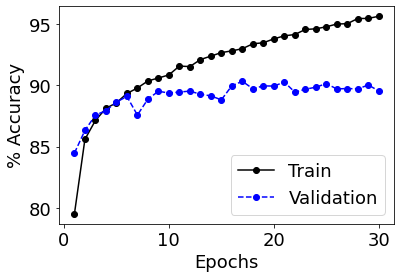

In [168]:
plt.rcParams.update({'font.size': 18})
plt.plot(epochs, train_accuracies, 'ko-', label = 'Train')
plt.plot(epochs, valid_accuracies, 'bo--', label = 'Validation')
plt.xlabel('Epochs'); plt.ylabel('% Accuracy')
plt.legend(); plt.show()

The accuracy of the validation set doesn't really improve after about 10 epochs, so we will stick to that for testing some of the other aspects of the network. Lets now look at how many layers in a fully connected neural network (here with 256 nodes). The new network is defined below, where the number of layers can be chosen. Note, the base model above has 2 hidden layers.  

#### Number of Layers Test

In [169]:
def linear_relu(dim_in, dim_out, num_layers):
    layers = []
    for i in range(num_layers-1):
        layers.extend([nn.Linear(dim_in, dim_out),
            nn.ReLU()])
    return layers

class NeuralNetwork_num_layers(nn.Module):
    ''' Number of layers is variable '''
    def __init__(self, num_layers):
        super(NeuralNetwork_num_layers, self).__init__()
        self.flatten = nn.Flatten()
        input_features = 28*28
        num_nodes = 256
        num_classes = 10
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_features, num_nodes),   # layer 1
            nn.ReLU(),  # activation function 
            *linear_relu(num_nodes, num_nodes, num_layers),
            nn.Linear(num_nodes, num_classes)       # output layer
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [170]:
# this took 10 minutes on my machine
train_loader, valid_loader, test_loader = update_data(128)

train_accuracies = []
valid_accuracies = []

layer_choices = range(2, 7)

for num_layers in layer_choices:
    model = NeuralNetwork_num_layers(num_layers)
    loss_function = nn.CrossEntropyLoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epochs = 10
    clear_output(wait=True)
    print(f"Currently testing {num_layers} Layers")
    for t in range(epochs):
        print(f"Currently on Epoch {t+1}....")
        train_accuracy,_ = train_loop_modified(train_loader, model, loss_function, optimizer)
        valid_accuracy,_ = validation_loop_modified(valid_loader, model, loss_function)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
print("Done!")

Currently testing 6 Layers
Currently on Epoch 1....
Currently on Epoch 2....
Currently on Epoch 3....
Currently on Epoch 4....
Currently on Epoch 5....
Currently on Epoch 6....
Currently on Epoch 7....
Currently on Epoch 8....
Currently on Epoch 9....
Currently on Epoch 10....
Done!


In [178]:
# num layers data results so you don't have to run test again
with open('exploration_data.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        lines[i] = line.strip('\n').strip()

num_layers = list(map(int, lines[5][7:].split(' ')))
train_accuracies = list(map(float, lines[6][6:].split(' ')))
valid_accuracies = list(map(float, lines[7][11:].split(' ')))
lines = None

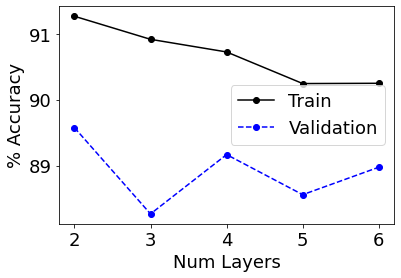

In [180]:
plt.rcParams.update({'font.size': 18})
plt.plot(num_layers, train_accuracies, 'ko-', label = 'Train')
plt.plot(num_layers, valid_accuracies, 'bo--', label = 'Validation')
plt.xlabel('Num Layers'); plt.ylabel('% Accuracy')
plt.legend(); plt.show()

Interestingly, the accuracy drastically decreased as the number of layers increased. Although this makes sense, as we are not adding any additional information by adding many symmetric layers. 

Lets try to find the optimal number of nodes. We will take our base network with 2 hidden layers, as this performed the best in the above test. 

#### Number of Nodes Test

In [209]:
class NeuralNetwork_num_nodes(nn.Module):
    '''
    A simple neural network model for the fashionMNIST data set 
    - the input features should be a matrix of size 28x28
    FULLY CONNECTED -- 2 HIDDEN LAYERS -- variable num_nodes
    '''
    def __init__(self, num_nodes):
        super(NeuralNetwork_num_nodes, self).__init__()
        self.flatten = nn.Flatten()
        input_features = 28*28
        num_classes = 10
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_features, num_nodes),   # layer 1
            nn.ReLU(),  # activation function 
            nn.Linear(num_nodes, num_nodes),        # layer 2
            nn.ReLU(),  # activation function 
            nn.Linear(num_nodes, num_classes)       # output layer
        )

    def forward(self, x):
        '''
        Execute the sequential stack for a flattened matrix and 
        return the raw logits 
        '''
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [210]:
train_loader, valid_loader, test_loader = update_data(128)

train_accuracies = []
valid_accuracies = []

node_choices = [(lambda n: 2**n)(x) for x in range(6,12)]

for num_nodes in node_choices:
    model = NeuralNetwork_num_nodes(num_nodes)
    loss_function = nn.CrossEntropyLoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epochs = 10
    clear_output(wait=True)
    print(f"Currently testing {num_nodes} Nodes")
    for t in range(epochs):
        print(f"Currently on Epoch {t+1}....")
        train_accuracy,_ = train_loop_modified(train_loader, model, loss_function, optimizer)
        valid_accuracy,_ = validation_loop_modified(valid_loader, model, loss_function)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
print("Done!")

Currently testing 2048 Nodes
Currently on Epoch 1....
Currently on Epoch 2....
Currently on Epoch 3....
Currently on Epoch 4....
Currently on Epoch 5....
Currently on Epoch 6....
Currently on Epoch 7....
Currently on Epoch 8....
Currently on Epoch 9....
Currently on Epoch 10....
Done!


In [218]:
# num layers data results so you don't have to run test again
with open('exploration_data.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        lines[i] = line.strip('\n').strip()

num_nodes = list(map(int, lines[9][:].split(' ')[1:]))
train_accuracies = list(map(float, lines[10][:].split(' ')[1:]))
valid_accuracies = list(map(float, lines[11][:].split(' ')[1:]))
lines = None

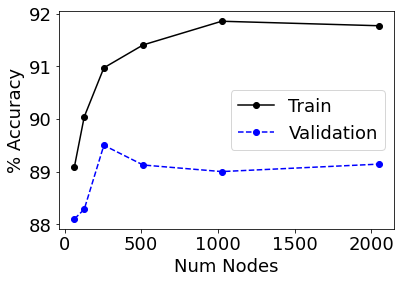

In [219]:
plt.rcParams.update({'font.size': 18})
plt.plot(node_choices, train_accuracies, 'ko-', label = 'Train')
plt.plot(node_choices, valid_accuracies, 'bo--', label = 'Validation')
plt.xlabel('Num Nodes'); plt.ylabel('% Accuracy')
plt.legend(); plt.show()

We can see that 2048 nodes does the best on the validation set, but the increase from 256, 512, and 1024. 2048 nodes also took a long time to execute, so we will stick to 256 for now. 

So far the best choices for the model are:

- Num Nodes: 2048, but 256 is similar and less computationally heavy
- Num Layers: 2
- Num Epochs: 10

Lets look at optimization on this structure.

Batch size for the optimizer can be modified. Remember the optimization parameters are updated after each batch.

#### Batch Size Test

In [227]:
# this takes 50 minutes on my machine
batch_sizes = [(lambda n: 2**n)(x) for x in range(0,12)]

train_accuracies = []
valid_accuracies = []
time_to_completion = []

for batch_size in batch_sizes:

    train_loader, valid_loader, test_loader = update_data(batch_size)

    model = NeuralNetwork()
    loss_function = nn.CrossEntropyLoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epochs = 10
    clear_output(wait=True)
    print(f"Testing for a batch size of {batch_size}")
    start = time.process_time()
    for t in range(epochs):
        print(f"Currently on Epoch {t+1}....")
        train_accuracy,_ = train_loop_modified(train_loader, model, loss_function, optimizer)
        valid_accuracy,_ = validation_loop_modified(valid_loader, model, loss_function)
    
    end = time.process_time()
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    time_to_completion.append(end-start)
    
print("Done!")

Testing for a batch size of 2048
Currently on Epoch 1....
Currently on Epoch 2....
Currently on Epoch 3....
Currently on Epoch 4....
Currently on Epoch 5....
Currently on Epoch 6....
Currently on Epoch 7....
Currently on Epoch 8....
Currently on Epoch 9....
Currently on Epoch 10....
Done!


In [232]:
ls = batch_sizes
for num in ls:
    print(num, end=' ')


1 2 4 8 16 32 64 128 256 512 1024 2048 

In [233]:
ls = train_accuracies
for num in ls:
    print(num, end=' ')

86.74374999999999 88.14166666666667 89.24166666666666 90.28541666666666 90.94791666666666 91.18125 91.25833333333333 90.99166666666667 90.41666666666667 89.78333333333333 88.59166666666667 87.2625 

In [234]:
ls = valid_accuracies
for num in ls:
    print(num, end=' ')

86.14166666666667 87.875 88.56666666666668 88.79166666666667 88.8 88.06666666666668 89.625 89.11666666666666 88.60833333333333 87.39166666666667 87.425 86.93333333333332 

In [235]:
ls = time_to_completion
for num in ls:
    print(num, end=' ')

3164.811485 1613.865718000001 751.7283559999996 341.006942 192.4119129999999 124.4057789999988 87.17478899999878 73.35671199999888 68.19115899999997 66.18156699999963 64.97983099999874 64.511899000001 

Text(-19, 25, 'BS = 128')

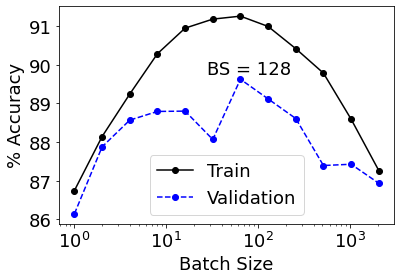

In [246]:
fig, ax1 = plt.subplots()

color = 'k'
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('% Accuracy', color=color)
ax1.semilogx(batch_sizes, train_accuracies, 'ko-', label = 'Train')
ax1.semilogx(batch_sizes, valid_accuracies, 'bo--',  label = 'Validation')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

x = batch_sizes[7]
y = valid_accuracies[7]
label = "BS = {}".format(x)

plt.annotate(label, (x,y), textcoords="offset points", xytext=(-19,25), ha='center') 

# ax2 = ax1.twinx()

# times_min = [(lambda n: n/60)(time) for time in time_to_completion]
# color = 'tab:blue'
# ax2.semilogx(batch_sizes, times_min, 'o--', color = color)
# ax2.set_ylabel('Execution Time (min)', color=color)
# ax2.tick_params(axis='y', labelcolor=color)

From this, we can see that a batch size of 128 is optimal for validation accuracy, as well as computation time. A batch size of 1 took nearly an hour, which makes sense as we were optimizing every image, since we update after every batch and this had a batch size of 1. 

In [84]:
def run_test(model = NeuralNetwork(),
            loss_function = nn.CrossEntropyLoss(),
            optimizer = torch.optim.Adam,
            learning = 1e-3,
            epochs=10,
            batch_size=128):

    train_loader, valid_loader, test_loader = update_data(batch_size)

    optimizer = optimizer(model.parameters(), lr=learning)

    start = time.process_time()
    loss_acc = 0
    for t in range(epochs):
        print(f"Currently on Epoch {t+1}....")
        train_accuracy, loss = train_loop_modified(train_loader, model, loss_function, optimizer)
        valid_accuracy,_ = validation_loop_modified(valid_loader, model, loss_function)
        loss_acc+=loss

    loss_acc/= epochs
    end = time.process_time()

    return train_accuracy, valid_accuracy, end-start, loss_acc

#### Learning Rate Test

In [188]:
# this took 22 minutes on my machine
learning_rates = [0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.013, 0.015, 0.017, 0.02, 0.025, 0.03, 0.07, 0.1, 0.2, 0.4]

train_accuracies = [None] * len(learning_rates)
valid_accuracies = [None] * len(learning_rates)
time_to_completion = [None] * len(learning_rates)
avg_loss_per_test = [None] * len(learning_rates)

for i, learning_rate in enumerate(learning_rates):
    clear_output(wait=True)
    print(f"Testing for a learning rate of {learning_rate}")

    #----
    model = NeuralNetwork()
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    learning = 1e-3
    epochs=10
    batch_size=128
    #----

    train_loader, valid_loader, test_loader = update_data(batch_size)

    loss_acc = 0
    start = time.process_time()
    for t in range(epochs):
        print(f"Currently on Epoch {t+1}....")
        train_accuracy, loss = train_loop_modified(train_loader, model, loss_function, optimizer)
        valid_accuracy,_ = validation_loop_modified(valid_loader, model, loss_function)
        loss_acc+=loss
        
    end = time.process_time()
    loss_acc/= epochs

    train_accuracies[i] = train_accuracy
    valid_accuracies[i] = valid_accuracy
    time_to_completion[i] = end - start
    avg_loss_per_test[i] = loss_acc
    
print("Done!")

Testing for a learning rate of 0.4
Currently on Epoch 1....
Currently on Epoch 2....
Currently on Epoch 3....
Currently on Epoch 4....
Currently on Epoch 5....
Currently on Epoch 6....
Currently on Epoch 7....
Currently on Epoch 8....
Currently on Epoch 9....
Currently on Epoch 10....
Done!


In [206]:
# num layers data results so you don't have to run test again
with open('exploration_data.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        lines[i] = line.strip('\n').strip()

learning_rates = list(map(float, lines[18][:].split(' ')[1:]))
train_accuracies = list(map(float, lines[19][:].split(' ')[1:]))
valid_accuracies = list(map(float, lines[20][:].split(' ')[1:]))
lines = None

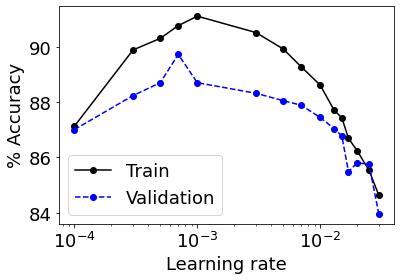

In [208]:
plt.rcParams.update({'font.size': 18})
plt.semilogx(learning_rates[:-4], train_accuracies[:-4], 'ko-', label = 'Train')
plt.semilogx(learning_rates[:-4], valid_accuracies[:-4], 'bo--', label = 'Validation')
plt.xlabel('Learning rate'); plt.ylabel('% Accuracy')
plt.legend(); plt.show()


Best LR = 0.0007

In [220]:
class NeuralNetwork_drop(nn.Module):
    '''
    - the input features should be a matrix of size 28x28
    FULLY CONNECTED -- 2 HIDDEN LAYERS
    '''
    def __init__(self, drop_p):

        super(NeuralNetwork_drop, self).__init__()
        self.flatten = nn.Flatten()
        input_features = 28*28
        num_nodes = 256
        num_classes = 10
        # drop_p = 0.25

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_features, num_nodes),   # layer 1
            nn.Dropout(p=drop_p),
            nn.ReLU(),  # activation function 
            nn.Linear(num_nodes, num_nodes),        # layer 2
            nn.Dropout(p=drop_p),
            nn.ReLU(),  # activation function 
            nn.Linear(num_nodes, num_classes)       # output layer
        )

    def forward(self, x):
        '''
        Execute the sequential stack for a flattened matrix and 
        return the raw logits 
        '''
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [247]:
np.linspace(0,0.2, 20)

array([0.        , 0.01052632, 0.02105263, 0.03157895, 0.04210526,
       0.05263158, 0.06315789, 0.07368421, 0.08421053, 0.09473684,
       0.10526316, 0.11578947, 0.12631579, 0.13684211, 0.14736842,
       0.15789474, 0.16842105, 0.17894737, 0.18947368, 0.2       ])

In [248]:
# this took 22 minutes on my machine
drop_rates = np.linspace(0,0.2, 20)

train_accuracies = [None] * len(drop_rates)
valid_accuracies = [None] * len(drop_rates)
time_to_completion = [None] * len(drop_rates)
avg_loss_per_test = [None] * len(drop_rates)

for i, drop in enumerate(drop_rates):
    clear_output(wait=True)
    print(f"Testing for a Drop rate of {drop}")

    #----
    model = NeuralNetwork_drop(drop)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
    epochs=10
    batch_size=128
    #----

    train_loader, valid_loader, test_loader = update_data(batch_size)

    loss_acc = 0
    start = time.process_time()
    for t in range(epochs):
        print(f"Currently on Epoch {t+1}....")
        train_accuracy, loss = train_loop_modified(train_loader, model, loss_function, optimizer)
        valid_accuracy,_ = validation_loop_modified(valid_loader, model, loss_function)
        loss_acc+=loss
        
    end = time.process_time()
    loss_acc/= epochs

    train_accuracies[i] = train_accuracy
    valid_accuracies[i] = valid_accuracy
    time_to_completion[i] = end - start
    avg_loss_per_test[i] = loss_acc

Testing for a Drop rate of 0.2
Currently on Epoch 1....
Currently on Epoch 2....
Currently on Epoch 3....
Currently on Epoch 4....
Currently on Epoch 5....
Currently on Epoch 6....
Currently on Epoch 7....
Currently on Epoch 8....
Currently on Epoch 9....
Currently on Epoch 10....


In [254]:
ls=valid_accuracies
for num in ls:
    print(num, end=' ')

88.75833333333333 88.71666666666667 88.94166666666666 88.675 88.41666666666667 88.575 88.9 88.925 88.38333333333334 89.28333333333333 87.68333333333334 89.09166666666667 88.24166666666666 88.88333333333334 88.425 88.575 88.63333333333333 88.40833333333333 88.33333333333333 88.69166666666666 

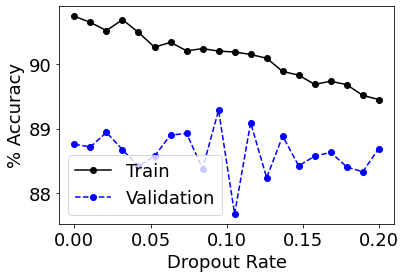

In [251]:
plt.rcParams.update({'font.size': 18})
plt.plot(drop_rates, train_accuracies, 'ko-', label = 'Train')
plt.plot(drop_rates, valid_accuracies, 'bo--', label = 'Validation')
plt.xlabel('Dropout Rate'); plt.ylabel('% Accuracy')
plt.legend(); plt.show()

In [ ]:
best_dr = 0.09473684210526316

In [266]:
class FinalNetwork(nn.Module):
    def __init__(self):

        super(FinalNetwork, self).__init__()
        self.flatten = nn.Flatten()
        input_features = 28*28
        num_nodes = 256
        num_classes = 10
        drop_p = 0.09

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_features, num_nodes),   # layer 1
            nn.Dropout(p=drop_p),
            nn.ReLU(),  # activation function 
            nn.Linear(num_nodes, num_nodes),        # layer 2
            nn.Dropout(p=drop_p),
            nn.ReLU(),  # activation function 
            nn.Linear(num_nodes, num_classes)       # output layer
        )

    def forward(self, x):
        '''
        Execute the sequential stack for a flattened matrix and 
        return the raw logits 
        '''
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [271]:
train_accuracies = [None] * len(drop_rates)
valid_accuracies = [None] * len(drop_rates)

#----
model = NeuralNetwork()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
epochs=10
batch_size=128
#----

train_loader, valid_loader, test_loader = update_data(batch_size)

for t in range(epochs):
    clear_output(wait=True)
    print(f"Currently on Epoch {t+1}....")
    train_accuracy, loss = train_loop_modified(train_loader, model, loss_function, optimizer)
    valid_accuracy,_ = validation_loop_modified(valid_loader, model, loss_function)

test_accuracy,_ = validation_loop_modified(test_loader, model, loss_function)

print(f"Training Accuracy is:\t {train_accuracy}")
print(f"Validation Accuracy is:\t {valid_accuracy}")
print(f"Test Accuracy is:\t {test_accuracy}")


Currently on Epoch 10....
Training Accuracy is:	 90.81666666666666
Validation Accuracy is:	 89.35
Test Accuracy is:	 88.42999999999999


In [273]:
train_accuracies = [None] * len(drop_rates)
valid_accuracies = [None] * len(drop_rates)

#----
model = NeuralNetwork()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs=10
batch_size=128
#----

train_loader, valid_loader, test_loader = update_data(batch_size)

for t in range(epochs):
    clear_output(wait=True)
    print(f"Currently on Epoch {t+1}....")
    train_accuracy, loss = train_loop_modified(train_loader, model, loss_function, optimizer)
    valid_accuracy,_ = validation_loop_modified(valid_loader, model, loss_function)

test_accuracy,_ = validation_loop_modified(test_loader, model, loss_function)

print(f"Training Accuracy is:\t {train_accuracy}")
print(f"Validation Accuracy is:\t {valid_accuracy}")
print(f"Test Accuracy is:\t {test_accuracy}")


Currently on Epoch 10....
Training Accuracy is:	 62.15208333333333
Validation Accuracy is:	 62.74166666666666
Test Accuracy is:	 61.480000000000004


### random things

In [172]:
def conv_relu_maxp(in_channels, out_channels, ks):
    return [nn.Conv2d(in_channels, out_channels,
                      kernel_size=ks,
                      stride=1,
                      padding=int((ks-1)/2), bias=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)]
            
def dropout_linear_relu(dim_in, dim_out, p_drop):
    return [nn.Dropout(p_drop),
            nn.Linear(dim_in, dim_out),
            nn.ReLU(inplace=True)]

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        # the super command makes my NeuralNetwork class
        # inherit all the methods within the nn.Module
        super(ConvolutionalNetwork, self).__init__()

        num_classes = 10

        self.features = nn.Sequential(
            *conv_relu_maxp(1, 16, 5),
            *conv_relu_maxp(16, 32, 5),
            *conv_relu_maxp(32, 64, 5)
        )
        # You must compute the number of features manuals to instantiate the
        # next FC layer
        # self.num_features = 64*3*3

        # Or you create a dummy tensor for probing the size of the feature maps
        probe_tensor = torch.zeros((1,1,28,28))
        out_features = self.features(probe_tensor).view(-1)

        self.classifier = nn.Sequential(
            *dropout_linear_relu(out_features.shape[0], 128, 0.5),
            *dropout_linear_relu(128, 256, 0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)  #  OR  x = x.view(-1, self.num_features)
        y = self.classifier(x)
        return y

In [173]:
train_accuracies = [None] * len(drop_rates)
valid_accuracies = [None] * len(drop_rates)

#----
model = NeuralNetwork()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs=10
batch_size=128
#----

train_loader, valid_loader, test_loader = update_data(batch_size)

for t in range(epochs):
    clear_output(wait=True)
    print(f"Currently on Epoch {t+1}....")
    train_accuracy, loss = train_loop_modified(train_loader, model, loss_function, optimizer)
    valid_accuracy,_ = validation_loop_modified(valid_loader, model, loss_function)

test_accuracy,_ = validation_loop_modified(test_loader, model, loss_function)

print(f"Training Accuracy is:\t {train_accuracy}")
print(f"Validation Accuracy is:\t {valid_accuracy}")
print(f"Test Accuracy is:\t {test_accuracy}")

Currently on Epoch 10....
Done!


Adam, crossentropyloss(), learning = 1e-3, epochs = 10, RelU 2 hidden layers

This project was built using tutorials in the pytorch doumentation:

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html